In [57]:
import numpy as np
from scipy.special import gammaln, gamma
from scipy import integrate
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from tqdm import trange

## Synthetic data

Code to sample a GGP distribution in the infinite activity case.

In [82]:
def sample_ggp(eta, sigma, tau, n_jumps=20000, T=None):
    def W(t, x):
        if tau > 0:
            log_output = np.log(eta) + np.log(1. - np.exp(-tau * (x - t))) - (1. + sigma)*np.log(t) - (t*tau) - np.log(tau) - gammaln(1. - sigma)
        else:
            log_output = np.log(eta) - gammaln(1. - sigma) - np.log(sigma) + np.log(t**(-sigma) - x**(-sigma))
        return np.exp(log_output)
    
    def inv_W(t, x):
        if tau > 0:
            return t - np.log(1. - gamma(1. - sigma) * x * tau / (eta * t**(-1.-sigma) * np.exp(-t * tau))) / tau
        else:
            log_output = -np.log(t**(-sigma) - sigma * gamma(1. - sigma) / eta * x) / sigma
            return np.exp(log_output)

    if T is None:
        T = np.exp(
            (np.log(eta) - np.log(sigma) - gammaln(1. - sigma) - np.log(n_jumps)) / sigma
        )
    else:
        if sigma > 0:
            n_jumps = np.floor(eta / sigma / gamma(1. - sigma)*T**(-sigma))
        else:
            n_jumps = np.floor(-eta * np.log(T));

    samples = []
    t, count = T, 0
    while True:
        r = -np.log(np.random.rand())
        if r > W(t, np.inf):
            break
        else:
            t_new = inv_W(t, r)
        if tau == 0 or np.log(np.random.rand()) < (-(1. + sigma) * np.log(t_new / t)):
            samples.append(t_new)
        t = t_new
        count += 1
        if count > 1e8:
            print("Threshold T is too large:", T)
            T = T / 10
            samples = []
            t, count = T, 0
    return np.array(samples)

In [83]:
eta, sigma, tau = 100., .5, 1.
T = 1e-8
ggp_samples = sample_ggp(eta, sigma, tau, T=T)

In [109]:
def sample_gbfry(eta, sigma, c, tau, T):
    eta0 = eta * (c**(tau - sigma)) / tau
    W = sample_ggp(eta0, sigma, c, T=T)
    beta = np.random.beta(tau, 1., W.size)
    W_normalised = W / beta
    return W_normalised

In [148]:
eta_true = 2000.
sigma_true = 0.1
c_true = 1.0
tau_true = 2.0
T = 1e-8
n = 100000
W_true = sample_gbfry(eta_true, sigma_true, c_true, tau_true, T)
counts = np.random.poisson(lam=n * W_true / np.sum(W_true))
counts = counts[counts > 0]

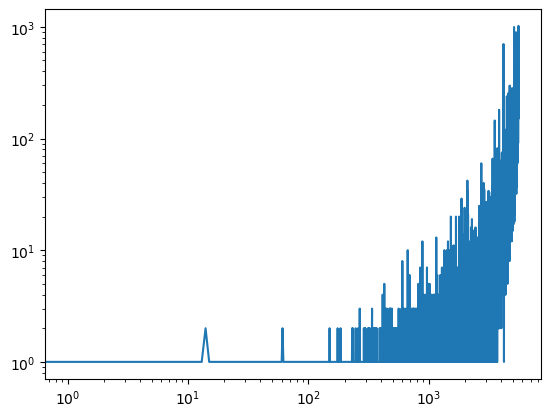

In [149]:
plt.loglog(counts)

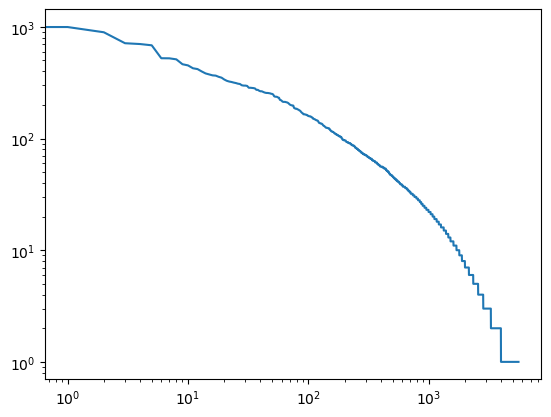

In [150]:
_ = plt.loglog(np.sort(counts)[::-1])

In [151]:
def gbfry_psi(t, eta, sigma, c, tau):
    return (eta / sigma) * integrate.quad(
        lambda x: ((t+x)**sigma - x**sigma) * x**(tau-sigma-1),
        0, c
    )[0]

def ll_gbfry(counts, ty, u, eta, sigma, c, tau):
    n = np.sum(counts)
    y = c / (1. + np.exp(-ty))
    ll = (n - 1) * np.log(u) - gbfry_psi(u, eta, sigma, c, tau) - gammaln(n)
    ll += counts.size * (np.log(eta) - gammaln(1. - sigma) - np.log(c))
    ll += np.sum(gammaln(counts - sigma) + (tau - sigma) * np.log(y) + np.log(c-y) - (counts - sigma) * np.log(y + u))
    return ll

def grad_ll_gbfry(ty, counts, u, sigma, c, tau):
    y = c / (1. + np.exp(-ty))
    grad = ((tau - sigma) / y - 1. / (c - y) - (counts - sigma) / (y + u)) * y * (c - y) / c
    return grad

def estimate_tau(counts):
    sorted_counts = np.sort(counts)[::-1]
    lr = LinearRegression().fit(np.log(np.arange(100, 200)).reshape(-1, 1), sorted_counts[100:200])
    tau = -1 / lr.coef_[0]
    return tau

def init_fit_gbfry(counts):
    eta = np.random.gamma(shape=1000., scale=1.)
    sigma = np.sum(counts == 1) / counts.size
    tau = estimate_tau(counts)
    W_sum = np.sum(sample_gbfry(eta, sigma, 1.0, tau, T=1e-8))
    u = np.random.gamma(shape=np.sum(counts), scale=1./W_sum)
    ty = np.random.randn(counts.size)
    return ty, u, eta, sigma, tau

def hmc_step(x0, U, grad_U, eps, L):
    x = x0
    r = np.random.randn(x.size)
    H_0 = U(x) + 0.5 * np.sum(r*r)
    for _ in range(L):
        r -= 0.5 * eps * grad_U(x)
        x += eps * r
        r -= 0.5 * eps * grad_U(x)
    H = U(x) + 0.5 * np.sum(r*r)
    if np.random.rand() > np.exp(np.min(H_0 - H, 0)):
        x = x0
    return x

def fit_gbfry(counts, n_samples, eps=5e-2, L=30):
    print("Init parameters..")
    ty, u, eta, sigma, tau = init_fit_gbfry(counts)
    c = 1.0
    print(f"Initial parameter values - u: {u}, eta: {eta}, sigma: {sigma}, tau: {tau}")

    log_u = np.log(u)
    log_eta = np.log(eta)
    logit_sigma = np.log(sigma) - np.log(1. - sigma)
    delta = tau - sigma
    log_delta = np.log(delta)

    results = {
        "ll": [],
        "eta": [],
        "sigma": [],
        "tau": [],
        "u": [],
        "y": [],
    }

    for _ in trange(n_samples):
        # sample ty
        U = lambda x: -ll_gbfry(counts, x, u, eta, sigma, c, tau)
        grad_U = lambda x: -grad_ll_gbfry(x, counts, u, sigma, c, tau)
        ty = hmc_step(ty, U, grad_U, eps, L)

        # sample eta
        log_eta_new = log_eta + 0.01 * np.random.randn()
        eta_new = np.exp(log_eta_new)
        log_r = ll_gbfry(counts, ty, u, eta_new, sigma, c, tau) - 0.5 * log_eta_new**2 \
            - ll_gbfry(counts, ty, u, eta, sigma, c, tau) + 0.5 * log_eta**2
        if np.random.rand() < np.exp(np.min(log_r, 0)):
            log_eta = log_eta_new
            eta = eta_new

        # sample sigma
        logit_sigma_new = logit_sigma + 0.01 * np.random.randn()
        sigma_new = 1. / (1. + np.exp(-logit_sigma_new))
        tau_new = sigma_new + delta;
        log_r = ll_gbfry(counts, ty, u, eta, sigma_new, c, tau_new) - 0.5 * logit_sigma_new**2 \
            - ll_gbfry(counts, ty, u, eta, sigma, c, tau) + 0.5 * logit_sigma**2
        if np.random.rand() < np.exp(np.min(log_r, 0)):
            logit_sigma = logit_sigma_new
            sigma = sigma_new
            tau = tau_new

        # sample delta
        log_delta_new = log_delta + 0.01 * np.random.randn()
        delta_new = np.exp(log_delta_new)
        tau_new = sigma + delta_new
        log_r = ll_gbfry(counts, ty, u, eta, sigma, c, tau_new) - 0.5 * log_delta_new**2 \
            - ll_gbfry(counts, ty, u, eta, sigma, c, tau) + 0.5 * log_delta**2
        if np.random.rand() < np.exp(np.min(log_r, 0)):
            delta = delta_new
            log_delta = log_delta_new
            tau = tau_new

        # sample u 
        log_u_new = log_u + 0.01 * np.random.randn()
        u_new = np.exp(log_u_new)
        log_r = ll_gbfry(counts, ty, u_new, eta, sigma, c, sigma+delta) - 0.5 * log_u_new**2 \
            - ll_gbfry(counts, ty, u, eta, sigma, c, sigma+delta) + 0.5 * log_u**2
        if np.random.rand() < np.exp(np.min(log_r, 0)):
            u = u_new
            log_u = log_u_new 

        #compute ll
        ll = ll_gbfry(counts, ty, u, eta, sigma, c, tau)

        results["ll"].append(ll)
        results["eta"].append(eta)
        results["sigma"].append(sigma)
        results["tau"].append(tau)
        results["u"].append(u)
        results["y"].append(c / (1. + np.exp(-ty)))

    return results

In [152]:
n_samples = 50000
results = fit_gbfry(counts, n_samples)

Init parameters..


/var/folders/71/xt377bp54z9gk07xhxg9b70m0000gn/T/ipykernel_47749/2974233793.py:5: RuntimeWarning: divide by zero encountered in divide
  W_normalised = W / beta
/var/folders/71/xt377bp54z9gk07xhxg9b70m0000gn/T/ipykernel_47749/2974233793.py:5: RuntimeWarning: overflow encountered in divide
  W_normalised = W / beta
/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/71/xt377bp54z9gk07xhxg9b70m0000gn/T/ipykernel_47749/2499720558.py:54: RuntimeWarning: divide by zero encountered in log
  log_u = np.log(u)
/var/folders/71/xt377bp54z9gk07xhxg9b70m0000gn/T/ipykernel_47749/2499720558.py:58: RuntimeWarning: invalid value encountered in log
  log_delta = np.log(delta)


Initial parameter values - u: 0.0, eta: 980.485731731537, sigma: 0.2859197985973746, tau: 0.010710370478030624


  0%|          | 0/50000 [00:00<?, ?it/s]/var/folders/71/xt377bp54z9gk07xhxg9b70m0000gn/T/ipykernel_47749/2499720558.py:10: RuntimeWarning: divide by zero encountered in log
  ll = (n - 1) * np.log(u) - gbfry_psi(u, eta, sigma, c, tau) - gammaln(n)
/var/folders/71/xt377bp54z9gk07xhxg9b70m0000gn/T/ipykernel_47749/2499720558.py:16: RuntimeWarning: overflow encountered in exp
  y = c / (1. + np.exp(-ty))
/var/folders/71/xt377bp54z9gk07xhxg9b70m0000gn/T/ipykernel_47749/2499720558.py:17: RuntimeWarning: divide by zero encountered in divide
  grad = ((tau - sigma) / y - 1. / (c - y) - (counts - sigma) / (y + u)) * y * (c - y) / c
/var/folders/71/xt377bp54z9gk07xhxg9b70m0000gn/T/ipykernel_47749/2499720558.py:17: RuntimeWarning: invalid value encountered in multiply
  grad = ((tau - sigma) / y - 1. / (c - y) - (counts - sigma) / (y + u)) * y * (c - y) / c
/var/folders/71/xt377bp54z9gk07xhxg9b70m0000gn/T/ipykernel_47749/2499720558.py:9: RuntimeWarning: overflow encountered in exp
  y = c / (1. 

In [139]:
def trace_plot(ax, x, target_value, value_name=""):
    ax.plot(x)
    ax.set_xlabel("Iteration")
    ax.set_ylabel(value_name)
    ax.axhline(y=target_value, color="yellow")

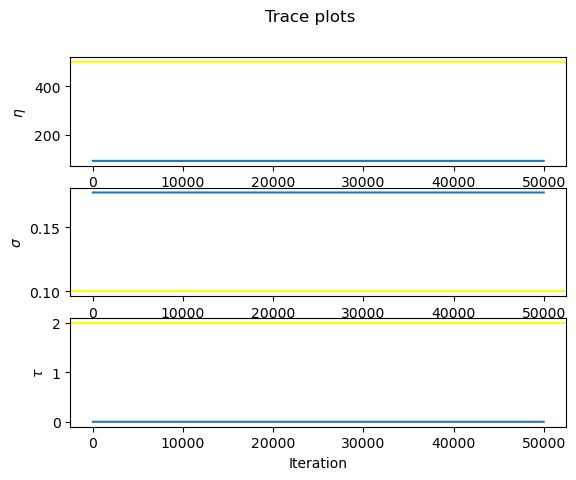

In [140]:
fig, ax = plt.subplots(3)
fig.suptitle("Trace plots")
trace_plot(ax[0], results["eta"], eta_true, r"$\eta$")
trace_plot(ax[1], results["sigma"], sigma_true, r"$\sigma$")
trace_plot(ax[2], results["tau"], tau_true, r"$\tau$")
plt.show()

In [142]:
results["ll"]

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan